In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import unicodedata as ud
from scipy.integrate import quad

In [2]:
def AMP_it(N, s, S, Y, l_p, sig_p, m0, q0, conv=1e-6, max_iter=1000):
    
    m = np.zeros(max_iter)
    q = np.zeros(max_iter)
    
    y = np.random.normal(loc=0, scale=sig_p, size=N)
    y = y/LA.norm(Y)
    s_n = s/LA.norm(s)
    z = y - np.dot(y,s_n)*s_n
    z = z/LA.norm(z)
    
    x = m0*s + np.sqrt(q0-m0**2)*(LA.norm(s))*z
    x_old = np.zeros(N)

    converged = False
    
    for t in range(max_iter):
        m[t] = np.dot(s, x)/N
#         print(m[0])
        q[t] = LA.norm(x)**2/N
    
#         print(q[0])
#         print(LA.norm(S - np.tensordot(x,x, axes=0),'fro')**2/N**2)
#         print(min(LA.norm(x-s)**2, LA.norm(x+s)**2)/N)
#         print("\n")
        A_old = (l_p/N)*np.dot(x_old,x_old)
        A = (l_p/N)*np.dot(x,x)
        B = np.sqrt(l_p/N)*np.dot(Y,x) - (l_p/(A_old+1/sig_p**2))*x_old
        x_new = B/(A+1/sig_p**2)
        
#         print(x_new)
        diff = np.mean((x_new-x)**2)
        x_old = x
        x = x_new
    
        if (t>2) & (diff < conv):
            converged = True
            m[t+1] = np.dot(s, x)/N
            q[t+1] = LA.norm(x)**2/N
            break
    
    if not converged:
        print("AMP didn't converge!")
    

    return m,q,t,x

In [3]:
def SE_AMP(l, l_p, sig, sig_p, m0, q0, t):
    
    mm = np.zeros(t)
    qq = np.zeros(t)
    
    m = m0
    q = q0
    
    m_new = 0
    q_new = 0
    
    max_iter = 1000
    conv = 1e-12
    
    converged = False
    
    for i in range(t):
        
        mm[i] = m
        qq[i] = q
        
        m_new = (np.sqrt(l*l_p)*(sig**2)*m)/(l_p*q+(1/sig_p**2))
        q_new = (l*l_p*(sig**2)*(m**2) + l_p*q)/((l_p**2)*(q**2)+1/sig_p**4+2*l_p*q/sig_p**2)
        
        diff = max((m_new-m)**2, (q_new - q)**2)
        m = m_new
        q = q_new
        
    
        if (i>2) & (diff < conv):
            print("converged")
            mm[i+1:] = m_new
            qq[i+1:] = q_new
            break
            
    
#     if not converged:
#         print(" didn't converge!")
        
    return mm, qq

In [4]:
def MSE(sigma, sigma_p, lamb, lamb_p):
    
    if (lamb <= 1/sigma**4 and lamb_p >= 1/sigma_p**4):
        return sigma**4 \
                + 1/lamb_p \
                - 2/((lamb_p**(1.5))*(sigma_p**2)) \
                + 1/((lamb_p**2)*(sigma_p**4))
    
    elif (lamb_p <= 1/sigma_p**4 and np.sqrt(lamb*lamb_p) >= 1/((sigma**2)*(sigma_p**2))) : 
        return (sigma**4)*((1-np.sqrt(lamb/lamb_p))**2) \
                +2/np.sqrt(lamb * lamb_p) \
                + 1/((lamb_p**2)*(sigma_p**4)) \
                + (2/lamb_p)*(sigma**2/sigma_p**2)*(1-np.sqrt(lamb/lamb_p)) \
                - 2/(lamb*lamb_p*(sigma**2)*(sigma_p**2))
    
    elif (lamb_p >= 1/sigma_p**4 and lamb >= 1/sigma**4) : 
        return (sigma**4)*((1-np.sqrt(lamb/lamb_p))**2) \
                +2/np.sqrt(lamb * lamb_p) \
                + 1/((lamb_p**2)*(sigma_p**4)) \
                + (2/lamb_p)*(sigma**2/sigma_p**2)*(1-np.sqrt(lamb/lamb_p)) \
                - 2/(lamb*lamb_p*(sigma**2)*(sigma_p**2))
          
    else:
          return sigma**4

In [5]:
### From the solution of previous homework to fix the numerical problem we have in case of high sparsity levels

def gaussian_pdf(x, mean = 0, variance = 1):
    '''
    Gaussian measure.
    '''
    return np.exp(-.5 * (x-mean)**2 / variance) / np.sqrt(2*np.pi*variance)

def damping(x_old, x_new, damp=0.5):
    '''
    Mix old and new iteration values.
    '''
    return x_old * damp + x_new * (1-damp)
    
def update_sparse(x:float, lims=10, *, sparsity):
    '''
    One step updated of the self-consistent equation for binary spiked matrix estimation.
    '''
    def integrand(z):
        arg = x + np.sqrt(x) * z

        enum = sparsity**2 * np.exp(-x/2) * np.sinh(arg)
        denom = (1-sparsity) + sparsity * np.exp(-x/2) * np.cosh(arg)

        return gaussian_pdf(z) * enum/denom
    
    return quad(integrand, -lims, lims)[0]
    
def iterate_sparse(init=0.001, tol=1e-7, max_steps = 1000, damp=0,
                   *, snr: float, sparsity: float):
    '''
    Iterate self-consistent equation for binary spiked matrix estimation.
    args:
        - initial value of m
        - tol: tolerance for convergence.
        - max_steps: maximum number of steps.
        - damp: damping level
        - snr: signal-to-noise ratio
        - sparsity: density of non-zero elements in signal.
    returns:
        - m iteration trajectory.
    '''
    m = np.zeros(max_steps)
    m[0] = init
    
    for t in range(max_steps-1):
        m_tmp = update_sparse(snr * m[t], sparsity=sparsity)
        m[t+1] = damping(m[t], m_tmp, damp=damp)
        
        if np.abs(m[t+1]-m[t]) < tol:
            break
    
    return m[:t+1]

In [14]:
EX = 100


N = 1000
l = 4
alpha =0.8

l_p = 4
sig_p = np.sqrt(alpha)

m0 = 1/np.sqrt(N)
q0 = m0

M_AMP = np.zeros((EX,10000))
Q_AMP = np.zeros((EX,10000))

M_MSE_AMP = np.zeros(EX)
V_MSE_AMP = np.zeros(EX)

Norm_M_MSE_AMP = np.zeros(EX)
Norm_V_MSE_AMP = np.zeros(EX)

T = np.zeros(EX)

for i in range(EX):
#     print(i)
    s = np.random.choice([-1,0, 1], size = N, p=[alpha/2,1-alpha,alpha/2])
    S = np.tensordot(s,s, axes=0)


    Z = np.triu(np.random.normal(0, 1, (N,N)))
    Z = Z + np.transpose(Z) + np.diag(np.random.normal(loc=0, scale=np.sqrt(2), size=(N)))


    Y = np.sqrt(l/N)*S + Z
    
    m_AMP, q_AMP, t,  xhat = AMP_it(N, s, S, Y,l_p,sig_p, m0, q0,max_iter=10000)
    
    M_MSE_AMP[i] =  LA.norm(S - np.tensordot(xhat,xhat, axes=0),'fro')**2/N**2
    V_MSE_AMP[i] = LA.norm(s - xhat)**2/N
    
    Norm_M_MSE_AMP[i] = LA.norm(S - np.tensordot(xhat,xhat, axes=0),'fro')**2/((LA.norm(S,'fro'))*(LA.norm(np.tensordot(xhat,xhat, axes=0),'fro')))
    Norm_V_MSE_AMP[i] = LA.norm(s - xhat)**2/((LA.norm(s))*(LA.norm(xhat)))
    
    M_AMP[i,:] = m_AMP
    if(t<9998):
        M_AMP[i, t+2:] = m_AMP[t+1]
    Q_AMP[i,:] = q_AMP
    if(t<9998):
        Q_AMP[i, t+2:] = q_AMP[t+1]
    
    T[i] = t
    
tt = np.int(max(T))
m_SE, q_SE = SE_AMP(l, l_p, np.sqrt(alpha), sig_p, m0, q0, tt+2)

converged




Matrix MSE of AMP : 0.4034162638501054
Matrix MSE of SE : 0.40234405726092487
Matrix MSE of Theory : 0.40234375
Matrix MSE in fully matched case: 0.330207822306265


Vector MSE of AMP : 0.3145241675697823
Matrix MSE of SE : 0.31250031513951193


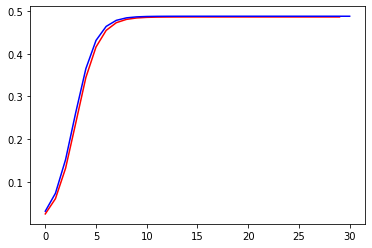

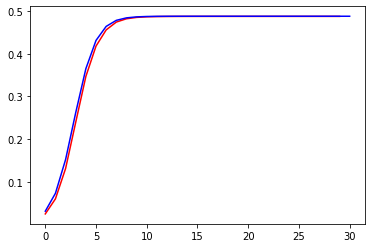

In [15]:
A = abs(M_AMP)
a = A.mean(0)

b = Q_AMP.mean(0)

m_star = iterate_sparse(snr = l, sparsity=alpha, damp=0.7)


plt.figure()
plt.plot(range(tt+1),a[:tt+1],'r')
plt.plot(range(tt+2), m_SE,'b')

plt.figure()
plt.plot(range(tt+1),b[:tt+1],'r')
plt.plot(range(tt+2), q_SE,'b')

# print('Normalized matrix Overlap of AMP :', (a[tt+1]**2)/((sig**2)*b[tt+1]))
# print('Normalized matrix Overlap of SE :', (m_SE[-1]**2)/((sig**2)*q_SE[-1]))

print("\n")

print('Matrix MSE of AMP :' ,M_MSE_AMP.mean())
print('Matrix MSE of SE :' ,alpha**2 + q_SE[-1]**2 - 2*m_SE[-1]**2)
print('Matrix MSE of Theory :' ,MSE(np.sqrt(alpha), sig_p, l, l_p))
print('Matrix MSE in fully matched case:' , alpha**2  - m_star[-1]**2)
print("\n")

print('Vector MSE of AMP :' ,V_MSE_AMP.mean())
print('Matrix MSE of SE :' ,alpha + q_SE[-1] - 2*m_SE[-1])


# m_star[i] = a[-1]

# MMSE_SRad = alpha - aa[-1]
# print(MMSE_SRad)